Replicate EV/REV plots for Octopamine/Rolipram sessions previously generated by Jahangir.

In [43]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy.core.neurons import Neurons
from neuropy.analyses.reactivation import ExplainedVariance
from neuropy.core.epoch import Epoch
from neuropy.core.session import ProcessData
from neuropy.plotting import plot_epochs
from neuropy.utils.plot_util import match_axis_lims

plot_save_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_octopamine_rollipram/Nat_plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up colors and rough injection times (from Jahangir plots)

In [54]:
sesh_csv = "/data3/Octopamine_Rolipram/Recording_Rats/OCT_ROL_sessions.csv"
sesh_df = pd.read_csv(sesh_csv, header=0)
sesh_df['session'] = pd.Categorical(sesh_df['session'], ['PBS', 'SAL', 'ROL', 'OCT'])
sesh_df = sesh_df.sort_values(["Animal", "session"]).reset_index().drop(columns = "index")
sesh_df

,Animal,session,date,directory,processed,inject 1,inject 2,accuracy
0,A11,PBS,2019_12_02,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
1,A11,ROL,2019_12_12,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
2,A11,OCT,2019_11_30,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
3,A14,PBS,2020_02_23,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.7,6.2,from_plot
4,A14,ROL,2020_02_26,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,5.0,6.5,from_plot
5,A14,OCT,2020_02_21,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.8,6.3,guess
6,BG,SAL,2019_10_21,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.8,6.3,from_plot
7,BG,ROL,2019_10_19,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.9,6.4,from_plot
8,BG,OCT,None,None,N,NaN,NaN,NaN
9,BGU,SAL,2021_08_11,/data3/Octopamine_Rolipram/Recording_Rats/BGU/...,Y,4.7,6.2,from_plot


In [58]:
rec_df[["session", "date"]].values.squeeze()

array(['OCT', '2019_11_30'], dtype=object)

In [17]:
colors_rs = "#5599ff"
colors_nsd = "k"
colors_sd = "#eb4034"
colors_maze = "g"
colors_pre = "#424242"
colors_sd_all = [colors_pre, colors_maze, colors_sd, colors_rs]

def adjust_lightness(color, amount=0.5):
    import colorsys

    import matplotlib.colors as mc

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    return mc.to_hex(c)

colors_all_light = [adjust_lightness(col, 1.2) for col in colors_sd_all]

### Run for all neurons

In [3]:
animal_df = sesh_df[sesh_df.Animal == "A14"]
rec_df = animal_df[animal_df.session == session]

dir_use = Path(str(rec_df["directory"].values[0]))
neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
neurons_use.get_neuron_type(['1', 'mua'])

NameError: name 'session' is not defined

Running EV for A11 PBS sessions
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.82it/s]


Running EV for A11 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:22<00:00,  5.26it/s]


Running EV for A11 OCT sessions
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:21<00:00,  5.69it/s]


Running EV for A14 PBS sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:22<00:00,  5.40it/s]


Running EV for A14 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:26<00:00,  4.50it/s]


Running EV for A14 OCT sessions
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:20<00:00,  5.67it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:22<00:00,  5.54it/s]


Running EV for BG ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:21<00:00,  5.51it/s]


Running EV for BGU SAL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:24<00:00,  4.94it/s]


Running EV for BGU ROL sessions
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:27<00:00,  4.23it/s]


Running EV for MR10 PBS sessions
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:19<00:00,  5.51it/s]


Running EV for MR10 ROL sessions
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:19<00:00,  5.57it/s]


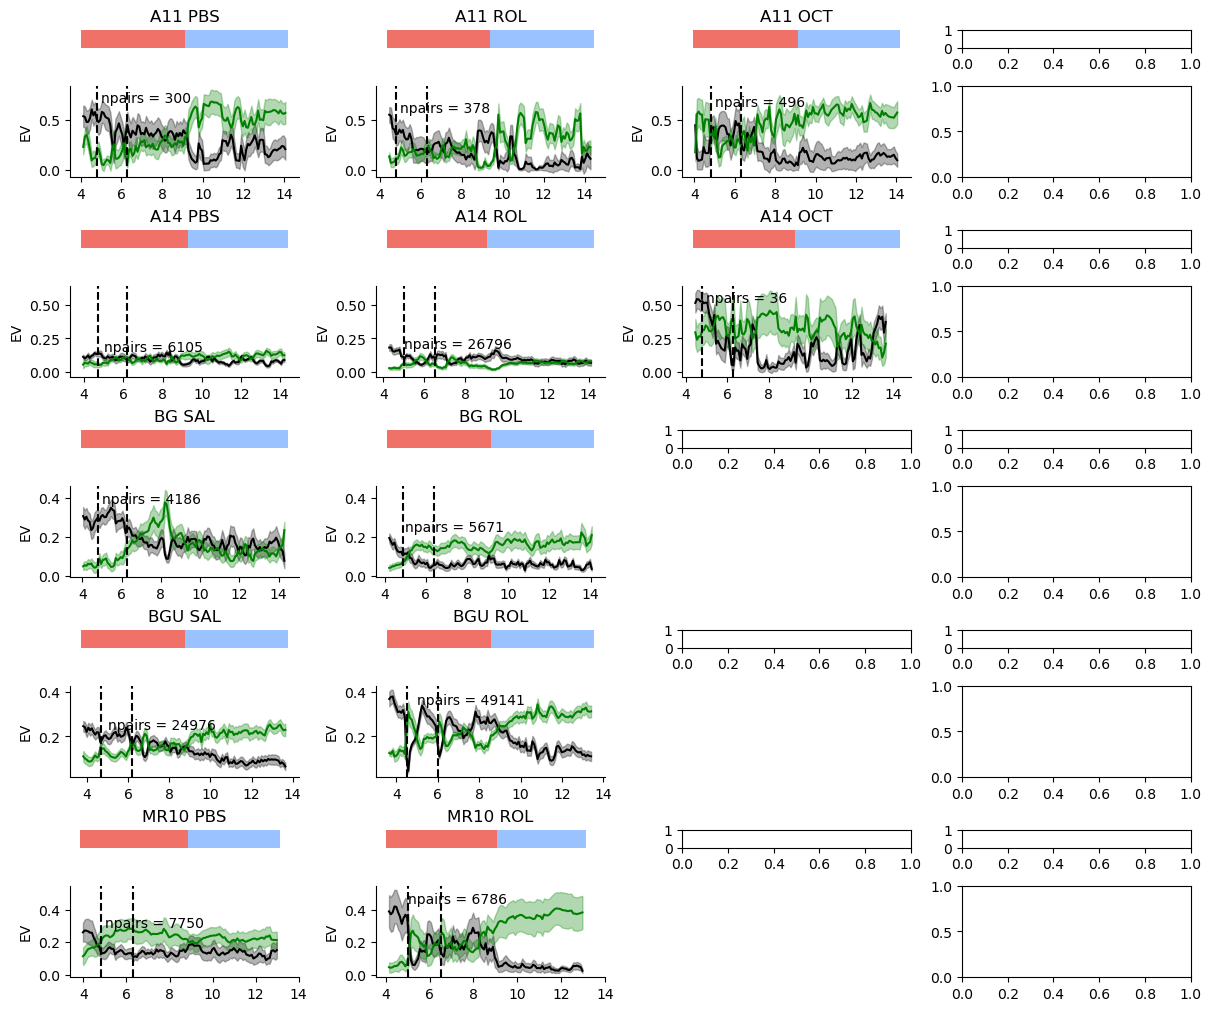

In [76]:
nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')
fig, axs = plt.subplots(nanimals*2, 4, figsize=(12, nanimals * 2), height_ratios=[1, 5]*nanimals, layout='compressed')
plot_zeroed = False
ev_dict_all = {}
for animal, axrow, axepoch in zip(sesh_df.Animal.unique(), axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    axrow_used = []
    for session, ax, axe in zip(animal_df.session, axrow, axepoch):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            # neurons_use = Neurons.from_dict(neurons_use)
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} sessions")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
            ev_dict_all[f"{animal}_{session}"] = ev

            # Plot reactivation
            if not plot_zeroed:
                ax.plot(ev.matching_time/3600, ev.ev, 'k-')
                ax.plot(ev.matching_time/3600, ev.rev, 'g-')
                ax.fill_between(ev.matching_time/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
                ax.fill_between(ev.matching_time/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in rec_df[["inject 1", "inject 2"]].values.squeeze()];
                ax.set_xticks([4, 6, 8, 10, 12, 14])
            else:
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std,
                                color='k', alpha=0.3)
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, 
                                color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in 
                 rec_df[["inject 1", "inject 2"]].values.squeeze() - ev.matching_time[0]/3600];
                ax.set_xticks([0, 2.5, 5, 7.5, 10])
            axe.set_title(f'{animal} {session}')
            
            ax.set_ylabel('EV')

            # Plot epochs
            if not plot_zeroed:
                plot_epochs(epochs[["sd", "post"]].scale(1/3600), collapsed=True, colors=colors_all_light[2:], ax=axe)
            else:
                epochs_zeroed = epochs[["sd", "post"]].scale(1/3600).shift(-epochs["sd"].scale(1/3600).starts[0])
                plot_epochs(epochs_zeroed, collapsed=True, colors=colors_all_light[2:], ax=axe)
            
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)
            sns.despine(ax=axe, left=True, bottom=True)
            axe.set_xticks([])
            axe.set_yticks([])
            
            axrow_used.append(ax)

            match_axis_lims([ax, axe], "x")

    # Match y limits on all EV plots in a row
    match_axis_lims(axrow_used, "y")

fig.savefig(plot_save_dir / "EV_all_neurons.pdf")

### Run for pyr neurons only

Running EV for A11 PBS sessions
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.04it/s]


Running EV for A11 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:03<00:00, 34.70it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for A11 OCT sessions
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:19<00:00,  6.06it/s]


Running EV for A14 PBS sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:21<00:00,  5.69it/s]


Running EV for A14 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:24<00:00,  4.95it/s]


Running EV for A14 OCT sessions
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:15<00:00,  7.42it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:21<00:00,  5.86it/s]


Running EV for BG ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.82it/s]


Running EV for BGU SAL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.84it/s]


Running EV for BGU ROL sessions
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:19<00:00,  6.11it/s]


Running EV for MR10 PBS sessions
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:18<00:00,  5.76it/s]


Running EV for MR10 ROL sessions
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:18<00:00,  5.83it/s]


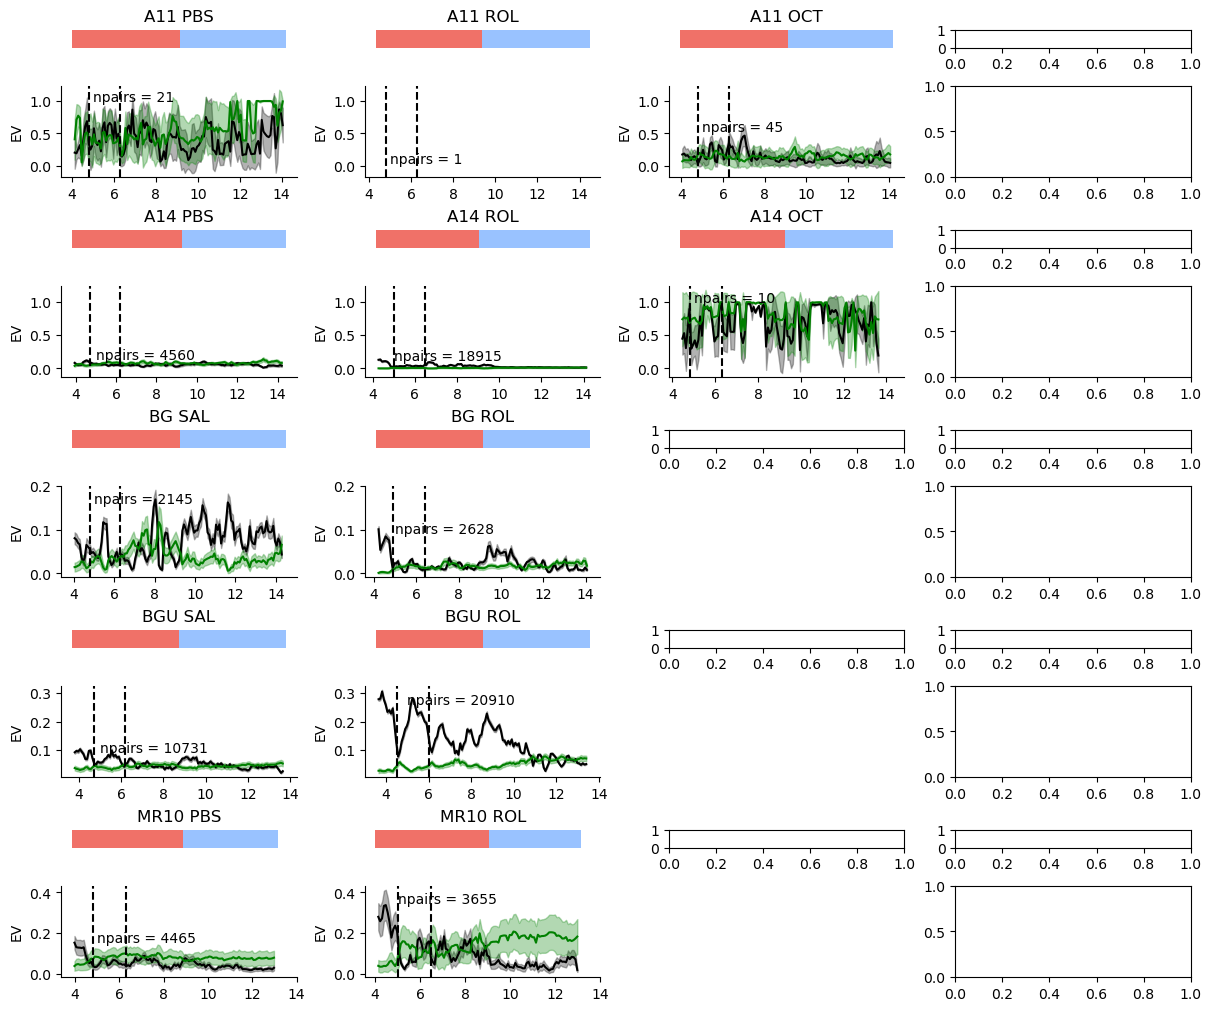

In [77]:
nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')
fig, axs = plt.subplots(nanimals*2, 4, figsize=(12, nanimals * 2), height_ratios=[1, 5]*nanimals, layout='compressed')
plot_zeroed = False
ev_dict_all = {}
for animal, axrow, axepoch in zip(sesh_df.Animal.unique(), axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    axrow_used = []
    for session, ax, axe in zip(animal_df.session, axrow, axepoch):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
            
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} sessions")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
            ev_dict_all[f"{animal}_{session}"] = ev

            # Plot reactivation
            if not plot_zeroed:
                ax.plot(ev.matching_time/3600, ev.ev, 'k-')
                ax.plot(ev.matching_time/3600, ev.rev, 'g-')
                ax.fill_between(ev.matching_time/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
                ax.fill_between(ev.matching_time/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in rec_df[["inject 1", "inject 2"]].values.squeeze()];
                ax.set_xticks([4, 6, 8, 10, 12, 14])
            else:
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std,
                                color='k', alpha=0.3)
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, 
                                color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in 
                 rec_df[["inject 1", "inject 2"]].values.squeeze() - ev.matching_time[0]/3600];
                ax.set_xticks([0, 2.5, 5, 7.5, 10])
            axe.set_title(f'{animal} {session}')
            
            ax.set_ylabel('EV')

            # Plot epochs
            if not plot_zeroed:
                plot_epochs(epochs[["sd", "post"]].scale(1/3600), collapsed=True, colors=colors_all_light[2:], ax=axe)
            else:
                epochs_zeroed = epochs[["sd", "post"]].scale(1/3600).shift(-epochs["sd"].scale(1/3600).starts[0])
                plot_epochs(epochs_zeroed, collapsed=True, colors=colors_all_light[2:], ax=axe)
            
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)
            sns.despine(ax=axe, left=True, bottom=True)
            axe.set_xticks([])
            axe.set_yticks([])
            
            axrow_used.append(ax)

            match_axis_lims([ax, axe], "x")

    # Match y limits on all EV plots in a row
    match_axis_lims(axrow_used, "y")

fig.savefig(plot_save_dir / "EV_pyr_only.pdf")

Running EV for A11 PBS session
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.00it/s]


Running EV for A11 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:03<00:00, 34.58it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.matching_time = np.mean(matching_windows, axis=1)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.control_time = np.mean(control_windows, axis=1)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for A11 OCT session
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:20<00:00,  5.87it/s]


Running EV for A14 PBS session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:22<00:00,  5.44it/s]


Running EV for A14 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:24<00:00,  4.86it/s]


Running EV for A14 OCT session
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:16<00:00,  7.30it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.matching_time = np.mean(matching_windows, axis=1)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.control_time = np.mean(control_windows, axis=1)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:21<00:00,  5.74it/s]


Running EV for BG ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.70it/s]


Running EV for BGU SAL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.72it/s]


Running EV for BGU ROL session
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:19<00:00,  6.03it/s]


Running EV for MR10 PBS session
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:19<00:00,  5.66it/s]


Running EV for MR10 ROL session
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:18<00:00,  5.70it/s]


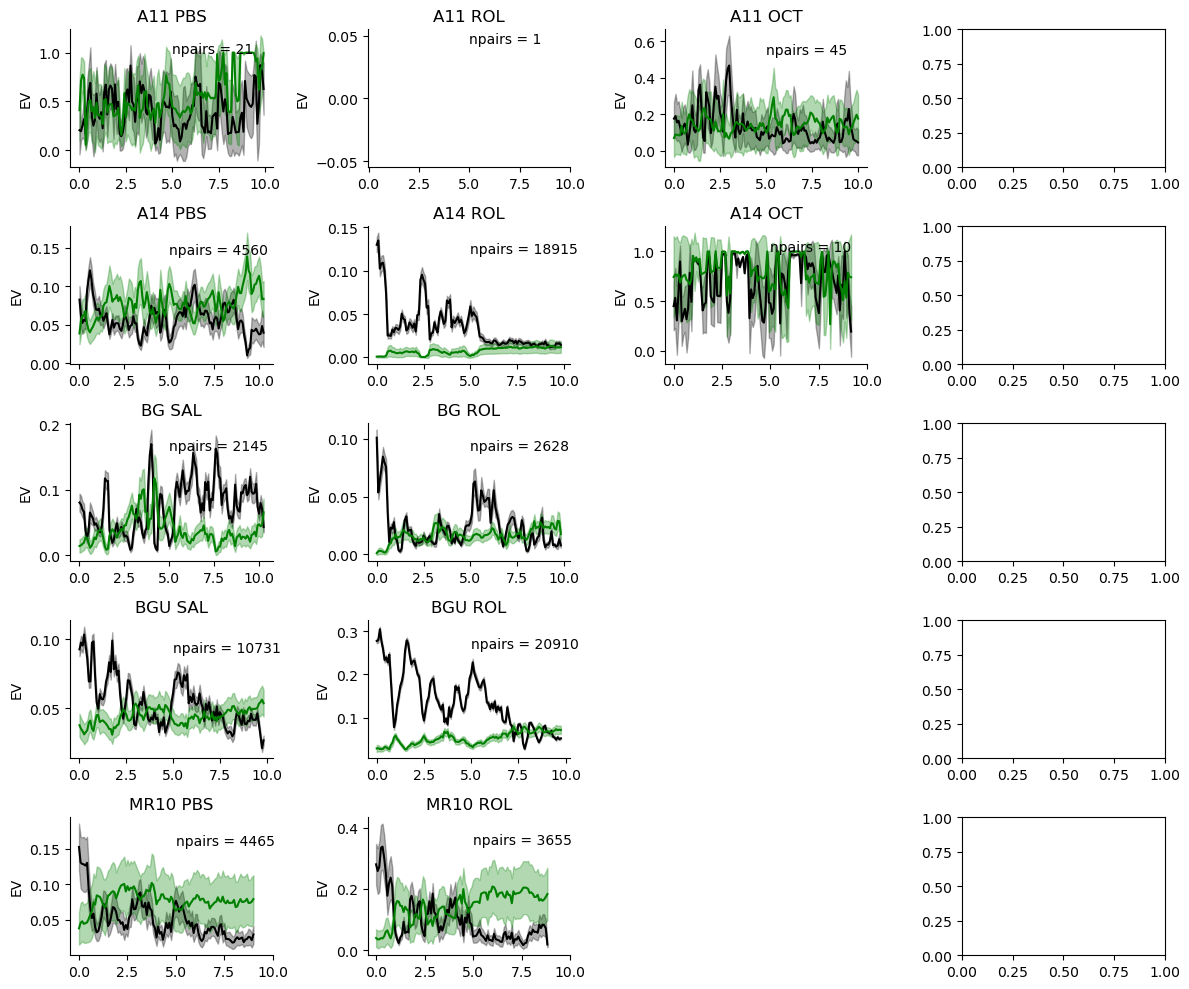

In [31]:
# nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')

# ev_dict_all = {}
# for animal, axrow in zip(sesh_df.Animal.unique(), axs):
#     animal_df = sesh_df[sesh_df.Animal == animal]
#     for session, ax in zip(animal_df.session, axrow):
#         rec_df = animal_df[animal_df.session == session]
#         if rec_df.directory.values[0] == "None":
#             sns.despine(ax=ax, left=True, bottom=True)
#             ax.set_xticks([])
#             ax.set_yticks([])
#         else:
#             dir_use = Path(str(rec_df["directory"].values[0]))
#             neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
#             neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
#             # neurons_use = Neurons.from_dict(neurons_use)
#             epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
#             print(f"Running EV for {animal} {session} session")
#             ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
#                                    epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
#             ev_dict_all[f"{animal}_{session}"] = ev
    
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
#             ax.set_title(f'{animal} {session}')
#             ax.set_xticks([0, 2.5, 5, 7.5, 10])
#             ax.set_ylabel('EV')
    
#             npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
#             ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
#             sns.despine(ax=ax)

# fig.savefig(plot_save_dir / "EV_pyr_only.pdf")

### Run for pyr only, exclude pairs with similar waveforms

Running EV for A11 PBS sessions
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.14it/s]


Running EV for A11 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:03<00:00, 35.23it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for A11 OCT sessions
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:21<00:00,  5.72it/s]


Running EV for A14 PBS sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:22<00:00,  5.48it/s]


Running EV for A14 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:25<00:00,  4.70it/s]


Running EV for A14 OCT sessions
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:14<00:00,  8.31it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:20<00:00,  5.92it/s]


Running EV for BG ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.78it/s]


Running EV for BGU SAL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:21<00:00,  5.63it/s]


Running EV for BGU ROL sessions
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:20<00:00,  5.85it/s]


Running EV for MR10 PBS sessions
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:20<00:00,  5.41it/s]


Running EV for MR10 ROL sessions
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:18<00:00,  5.76it/s]


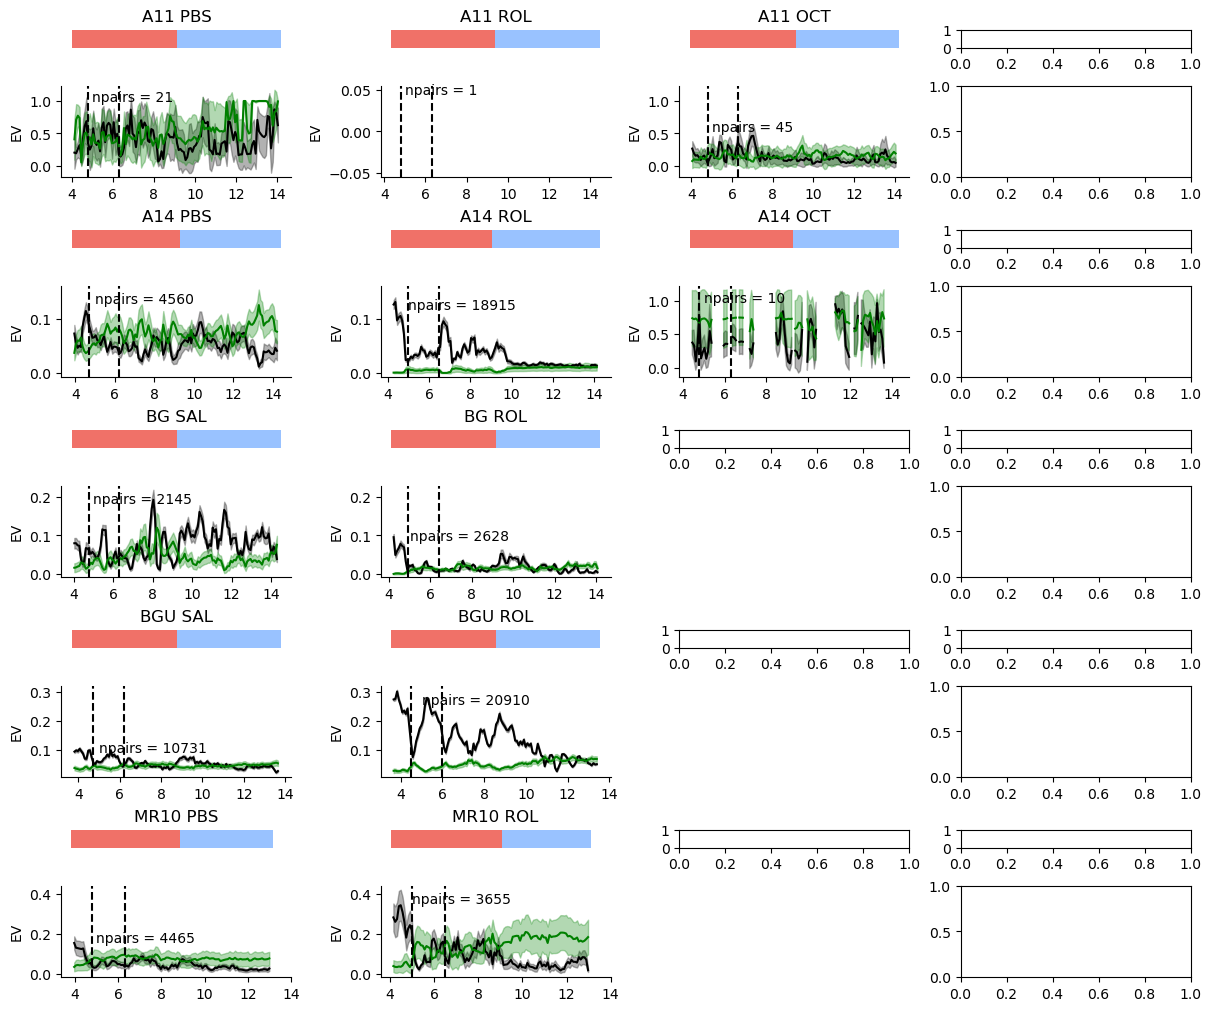

In [79]:
nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')
fig, axs = plt.subplots(nanimals*2, 4, figsize=(12, nanimals * 2), height_ratios=[1, 5]*nanimals, layout='compressed')
plot_zeroed = False
ev_dict_all = {}
for animal, axrow, axepoch in zip(sesh_df.Animal.unique(), axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    axrow_used = []
    for session, ax, axe in zip(animal_df.session, axrow, axepoch):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
            wave_similarity = neurons_use.get_waveform_similarity()
            pairs_bool = wave_similarity < 0.8
            
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} sessions")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250,
                                   pairs_bool=pairs_bool)
            ev_dict_all[f"{animal}_{session}"] = ev

            # Plot reactivation
            if not plot_zeroed:
                ax.plot(ev.matching_time/3600, ev.ev, 'k-')
                ax.plot(ev.matching_time/3600, ev.rev, 'g-')
                ax.fill_between(ev.matching_time/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
                ax.fill_between(ev.matching_time/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in rec_df[["inject 1", "inject 2"]].values.squeeze()];
                ax.set_xticks([4, 6, 8, 10, 12, 14])
            else:
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std,
                                color='k', alpha=0.3)
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, 
                                color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in 
                 rec_df[["inject 1", "inject 2"]].values.squeeze() - ev.matching_time[0]/3600];
                ax.set_xticks([0, 2.5, 5, 7.5, 10])
            axe.set_title(f'{animal} {session}')
            
            ax.set_ylabel('EV')

            # Plot epochs
            if not plot_zeroed:
                plot_epochs(epochs[["sd", "post"]].scale(1/3600), collapsed=True, colors=colors_all_light[2:], ax=axe)
            else:
                epochs_zeroed = epochs[["sd", "post"]].scale(1/3600).shift(-epochs["sd"].scale(1/3600).starts[0])
                plot_epochs(epochs_zeroed, collapsed=True, colors=colors_all_light[2:], ax=axe)
            
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)
            sns.despine(ax=axe, left=True, bottom=True)
            axe.set_xticks([])
            axe.set_yticks([])

            if npairs > 20:
                axrow_used.append(ax)

            match_axis_lims([ax, axe], "x")

    # Match y limits on all EV plots in a row
    match_axis_lims(axrow_used, "y")

fig.savefig(plot_save_dir / "EV_pyr_only_wave_exclude.pdf")

In [ ]:
# nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')

# ev_dict_all = {}
# for animal, axrow in zip(sesh_df.Animal.unique(), axs):
#     animal_df = sesh_df[sesh_df.Animal == animal]
#     for session, ax in zip(animal_df.session, axrow):
#         rec_df = animal_df[animal_df.session == session]
#         if rec_df.directory.values[0] == "None":
#             sns.despine(ax=ax, left=True, bottom=True)
#             ax.set_xticks([])
#             ax.set_yticks([])
#         else:
#             dir_use = Path(str(rec_df["directory"].values[0]))
            
#             neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
#             neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
#             wave_similarity = neurons_use.get_waveform_similarity()
#             pairs_bool = wave_similarity < 0.8
            
#             epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
#             print(f"Running EV for {animal} {session} session")
#             ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
#                                    epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250,
#                                    pairs_bool=pairs_bool)
#             ev_dict_all[f"{animal}_{session}"] = ev
    
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
#             ax.set_title(f'{animal} {session}')
#             ax.set_xticks([0, 2.5, 5, 7.5, 10])
#             ax.set_ylabel('EV')
    
#             # npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
#             npairs = int(np.triu(pairs_bool, 1).reshape(-1).sum())
#             ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
#             sns.despine(ax=ax)

# fig.savefig(plot_save_dir / "EV_pyr_only_wave_exclude.pdf")

In [ ]:
pairs_bool

In [ ]:
neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
neurons_use.get_neuron_type(["1", "pyr"]).neuron_type

In [ ]:
fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2))
npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
sns.despine(ax=axs[1][1], left=True, bottom=True)
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])